In this practical, we will learn different techniques of applying linear and logistic regression:

- Using VIF to deal with multicollinearity
- Building and interpreting a linear regression model
- Building and interpreting a logistic regression model

This week we will again be working with Python, using **pandas**, **scikit-learn**, and [**statsmodels**](https://www.statsmodels.org/stable/index.html). **statsmodel** is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. It provides a nice summary function for linear regression.

Let's first import the basic libraries we will need. **Run the script below to get started.**

In [21]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

# Data description

The dataset you will use relates to daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C, along with weather and seasonal information. The goal here is to predict how many bikes will be rented depending on the weather and the day. The original data can be downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The dataset used in this workshop has been slightly processed by Christoph Molnar. You can find the processing R-script in this [Github repository](https://github.com/christophM/interpretable-ml-book/blob/master/R/get-bike-sharing-dataset.R). Here, the dataset is provided as a csv file on Moodle.

Here is a list of the variables in the dataset:

- Count of bicycles including both casual and registered users. The count is used as the response in the regression task.
- Indicator of the season, either spring, summer, fall or winter.
- Indicator whether the day was a holiday or not.
- The year, either 2011 or 2012.
- Number of days since the January 1st, 2011 (the first day in the dataset). This predictor was introduced to take account of the trend over time.
- Indicator whether the day was a working day or weekend.
- The weather situation on that day. One of:
 - **'GOOD'**: clear, few clouds, partly cloudy, cloudy
 - **'MISTY'**: mist + clouds, mist + broken clouds, mist + few clouds, mist
 - **'RAIN/SNOW/STORM'**: light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds, heavy rain + ice pallets + thunderstorm + mist, snow + mist
- Temperature in degrees Celcius.
- Relative humidity in percent (0 to 100).
- Wind speed in km/h.

Based on what you know from using Pandas over the last few weeks, import the Boston housing dataset as a Pandas dataframe (call it `bike_rental`), inspect the data, calculate summary statistics on all attributes, and general simple plots of pairs of attributes.

In [4]:
bike_rental = pd.read_csv('daily_count_rent_bike.csv')

In [5]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              731 non-null    int64  
 1   season           731 non-null    object 
 2   yr               731 non-null    int64  
 3   mnth             731 non-null    object 
 4   holiday          731 non-null    object 
 5   weekday          731 non-null    object 
 6   workingday       731 non-null    object 
 7   weathersit       731 non-null    object 
 8   temp             731 non-null    float64
 9   hum              731 non-null    float64
 10  windspeed        731 non-null    float64
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [6]:
bike_rental.head()

,cnt,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,985,SPRING,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,0
1,801,SPRING,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,1
2,1349,SPRING,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,2
3,1562,SPRING,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.4000,59.0435,10.7398,3
4,1600,SPRING,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.6670,43.6957,12.5223,4


In `bike_rental`, there are two data types: categorical (aka `object`), and numerical (including `int64` and `float64`). 

Before undertaking regression, several steps should be done, which include:
- Converting categorical variables into dummy variables
- Dealing with multicollinearity (and removing some variables if necessary)

## Encoding of categorical variables
First, we need to convert categorical variables into dummy variables (or indicator variable), using `One-Hot Encoding`.

In [7]:
bike_rental_numeric = pd.get_dummies(bike_rental)

In [8]:
# check out the new dataFrame
bike_rental_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   yr                          731 non-null    int64  
 2   temp                        731 non-null    float64
 3   hum                         731 non-null    float64
 4   windspeed                   731 non-null    float64
 5   days_since_2011             731 non-null    int64  
 6   season_FALL                 731 non-null    uint8  
 7   season_SPRING               731 non-null    uint8  
 8   season_SUMMER               731 non-null    uint8  
 9   season_WINTER               731 non-null    uint8  
 10  mnth_APR                    731 non-null    uint8  
 11  mnth_AUG                    731 non-null    uint8  
 12  mnth_DEZ                    731 non-null    uint8  
 13  mnth_FEB                    731 non

Remember that, a cateogircal variable of K categories or levels, usually enters a regression as a sequence of K-1 dummy variables. The level that is left out becomes the **reference level**, and this is important for interpreting the regression model.

Here we manually choose the reference level for each categorical variable and exclude them from the DataFrame. You can change the reference levels if you want.

In [9]:
bike_rental_final = bike_rental_numeric.drop(['season_SPRING', 'mnth_JAN', 'holiday_NO HOLIDAY', 'weekday_MON', 'workingday_WORKING DAY', 'weathersit_GOOD'], axis=1)

# double check the result
bike_rental_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   yr                          731 non-null    int64  
 2   temp                        731 non-null    float64
 3   hum                         731 non-null    float64
 4   windspeed                   731 non-null    float64
 5   days_since_2011             731 non-null    int64  
 6   season_FALL                 731 non-null    uint8  
 7   season_SUMMER               731 non-null    uint8  
 8   season_WINTER               731 non-null    uint8  
 9   mnth_APR                    731 non-null    uint8  
 10  mnth_AUG                    731 non-null    uint8  
 11  mnth_DEZ                    731 non-null    uint8  
 12  mnth_FEB                    731 non-null    uint8  
 13  mnth_JUL                    731 non

## Checking the correlation between variables

In regression, `collinearity` is the problem when **two** variables are highly correlated and therefore contain similar information about the variance within the dataset. Colinearity among variables can be detected by creating a correlation matrix.

On the other hand, `multicollinearity` emerges when three or more variables, which are highly correlated, are included in a model. It can emerge even when each pair of variables involved are not colinear. For example, think of the four dummy variables relating to seasons in the `bike_rental_numeric` dataset.  

You can check the colinearity between attributes using a correlation matrix as below. Think of these two questions:

- **What can you say about this plot? For example, which pair of variables are highly correlated, and can you explain it?**
- **Can you use the correlation matrix to deal with multicolinearity, for example, by removing one of the two variables if their correlation is above 0.75?** (Hint: a short answer is NO)

Text(0.5, 1.0, 'Correlation Matrix')

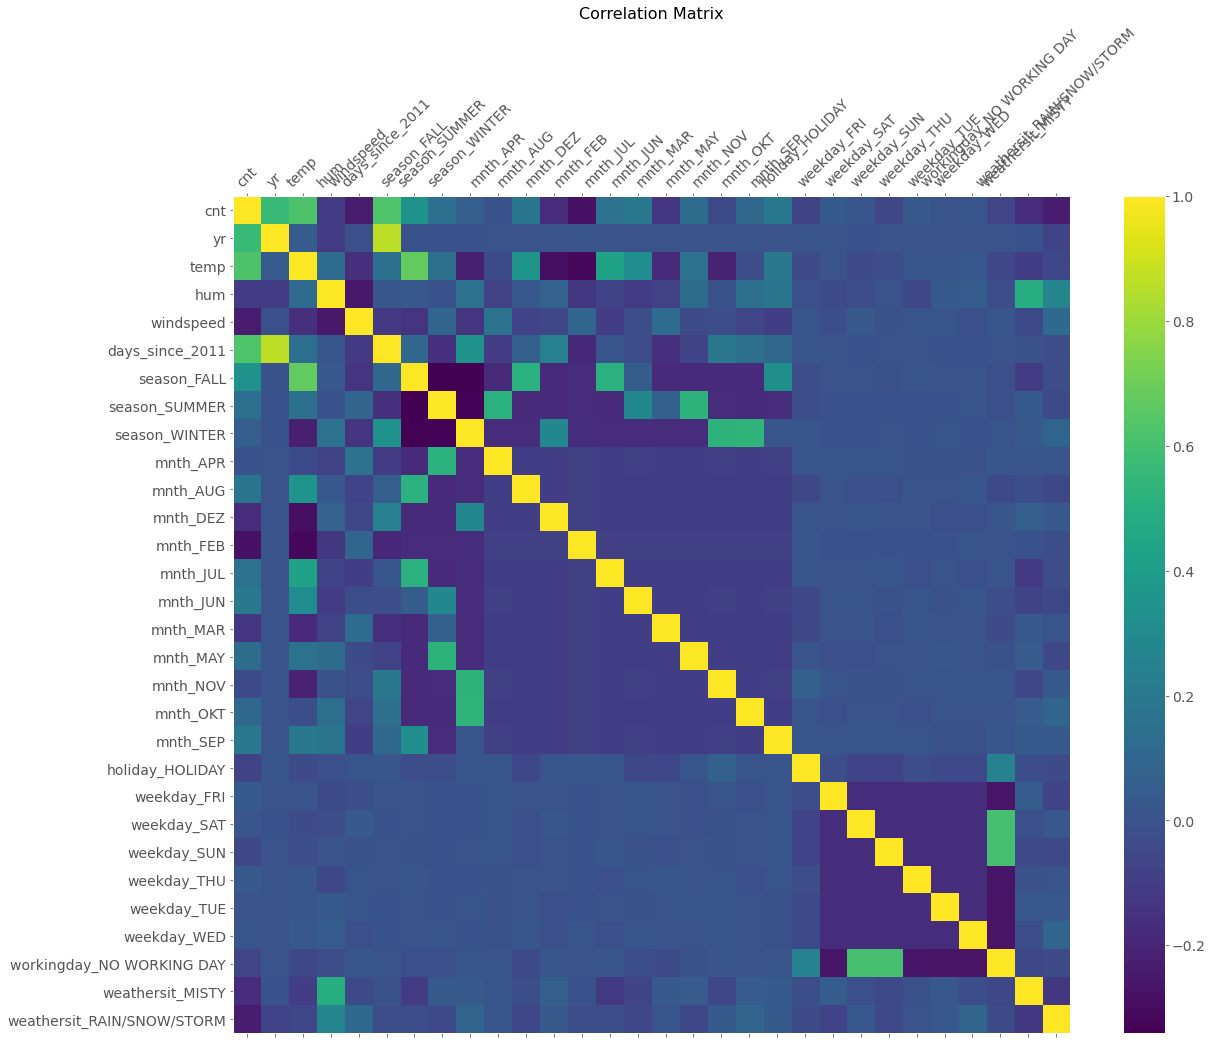

In [10]:
df = bike_rental_final
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# Dealing with multicollinearity
## An example of multicollinearity between four seasons

Here we build a model of predicting bicycle usage using the season. If all four seasons are used, obviously there is strong multicollinearity between them. For any sample, there is:

`season_SPRING + season_SUMMER + season_FALL + season_WINTER = 1`

We build a linear regression model using all four seasons.

There is a warning saying *This might indicate that there are strong multicollinearity problems or that the design matrix is singular.* The `statsmodels` package gives this warning when the **condition number** is above the threshold of 1000, which is quite sensitive for most real-world applied analysis. 

There are multiple reasons for the overlarge condition number:
- Multicolliearity between predictors;
- Different scales of variables.

Later, you will see that, even if the multicollinearity is tackled using VIF, the condition number would still be large. In this modele, we can ignore these warnings on condition that we explicitly deal with the multicollinearity issue.

In [11]:
bike_rental_seasons = bike_rental_numeric.loc[:,['cnt', 'season_SPRING', 'season_SUMMER', 'season_FALL', 'season_WINTER']]

In [12]:
model_cnt_seasons = sm.formula.ols('cnt ~ season_SPRING + season_SUMMER + season_FALL + season_WINTER', bike_rental_seasons).fit()
model_cnt_seasons.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     128.8
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           6.72e-67
Time:                        12:09:26   Log-Likelihood:                -6413.9
No. Observations:                 731   AIC:                         1.284e+04
Df Residuals:                     727   BIC:                         1.285e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3593.7860     46.425     77.411      0.000    3502.643    3684.929
season_SPRING  -989.6534    101.550     -9.746      0.000   -1189.019    -790.288
season_SUMMER  1398.5455    100.893     13.862      0.000    1200.470    1596.621
season_FALL    2050.5171    100.043     20.496      0.000    1854.109    2246.925
season_WINTER  1134.3769    102.224     11.097      0.000     933.687    1335.067
==============================================================================
Omnibus:                        3.050   Durbin-Watson:                   0.469
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.765
Skew:                           0.080   Prob(JB):                        0.251
Kurtosis:                       2.745   Cond. No.                     1.57e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.72e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

To eliminate the multicollinearty of seasons, we can build a linear regression model excluding `spring`.

**How does the R-squared value compare with the previous model?**

In [13]:
model_cnt_seasons_noSpring = sm.formula.ols('cnt ~ season_SUMMER + season_FALL + season_WINTER', bike_rental_seasons).fit()
model_cnt_seasons_noSpring.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     128.8
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           6.72e-67
Time:                        12:09:26   Log-Likelihood:                -6413.9
No. Observations:                 731   AIC:                         1.284e+04
Df Residuals:                     727   BIC:                         1.285e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2604.1326    116.598     22.334      0.000    2375.223    2833.042
season_SUMMER  2388.1989    164.221     14.543      0.000    2065.795    2710.603
season_FALL    3040.1706    163.352     18.611      0.000    2719.472    3360.869
season_WINTER  2124.0303    165.588     12.827      0.000    1798.943    2449.118
==============================================================================
Omnibus:                        3.050   Durbin-Watson:                   0.469
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.765
Skew:                           0.080   Prob(JB):                        0.251
Kurtosis:                       2.745   Cond. No.                         4.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Using VIF to deal with multicollinearity

If there are a large number of predictor variables, it is very difficult to manually test multicollinearity between them. Here we use VIF to automatically deal with multicollinearity.

The `Variance Inflation Factor` (VIF) is a measure of multicolinearity among predictors within a multiple regression task. It is the quotient of the variance in a model with multiple predictors by the variance of a model with a single predictor. More explanation of the theory can be found [here](https://online.stat.psu.edu/stat501/lesson/12/12.4). 

Steps for using VIF to deal with multicolineartiy are:

1. Initialise ```L``` as the list of independent variables. (*HINT*: the response variable is not needed here)
2. Calculate the VIF for each variable in ```L```. (*HINT*: the order of computing VIF is irrelevant).
3. If the highest VIF is larger than the threshold, remove the variable from the list ```L```.
4. Repeat Step 2-3, until no VIF is larger than the threshold.
5. Return ```L```.

Below is an example of using VIF on the `bike_rental` dataset. Note that the `statsmodels` package is used.

In [14]:
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

If we use the `drop_column_using_vif_` function on `bike_rental_seasons`, one of the season variable would be dropped.

**Think of this question: why is only one season variable dropped?**

In [15]:
bike_rental_seasons_new = drop_column_using_vif_(bike_rental_seasons.drop('cnt', axis=1))

Dropping: season_SPRING


C:\Users\HuanfaChen\Anaconda3\envs\sds2020\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\HuanfaChen\Anaconda3\envs\sds2020\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


*Hint*: You can ignore the warnings of `RuntimeWarning: divide by zero encountered in double_scalars`.

# Building and interpreting a linear regression model

## Building the model

We are going to use VIF on the whole dataset, build a linear model, and interpret the result.

In [16]:
bike_rental_final.columns

Index(['cnt', 'yr', 'temp', 'hum', 'windspeed', 'days_since_2011',
       'season_FALL', 'season_SUMMER', 'season_WINTER', 'mnth_APR', 'mnth_AUG',
       'mnth_DEZ', 'mnth_FEB', 'mnth_JUL', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY',
       'mnth_NOV', 'mnth_OKT', 'mnth_SEP', 'holiday_HOLIDAY', 'weekday_FRI',
       'weekday_SAT', 'weekday_SUN', 'weekday_THU', 'weekday_TUE',
       'weekday_WED', 'workingday_NO WORKING DAY', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')

In [17]:
# using VIF on the bike_rental dataset

df_predictors_selected_VIF = drop_column_using_vif_(bike_rental_final.drop('cnt', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

C:\Users\HuanfaChen\Anaconda3\envs\sds2020\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: holiday_HOLIDAY
Dropping: days_since_2011
Dropping: season_FALL
Dropping: workingday_NO WORKING DAY
Dropping: temp
Dropping: season_WINTER
Dropping: season_SUMMER
The columns remaining after VIF selection are:
Index(['yr', 'hum', 'windspeed', 'mnth_APR', 'mnth_AUG', 'mnth_DEZ',
       'mnth_FEB', 'mnth_JUL', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY', 'mnth_NOV',
       'mnth_OKT', 'mnth_SEP', 'weekday_FRI', 'weekday_SAT', 'weekday_SUN',
       'weekday_THU', 'weekday_TUE', 'weekday_WED', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')


Now we can fit a linear regression model after dealing with the multicollinearity. There are at least two different ways to forumlate a linear regression model using `statsmodels`.

1. Using `statsmodels.api.formula.ols`. A specific formula is needed.
2. Using `statsmodels.api.OLS`. You don't need to write the formula. Assign the `y` and `X` in the linear regression to the `endog` and `exog` parameters, respectively. 

Now we use the `statsmodels.api.OLS` to build and fit a linear regression model.

In [18]:
model_bike_rental = sm.OLS(endog=bike_rental_final[['cnt']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_bike_rental.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     127.4
Date:                Mon, 26 Oct 2020   Prob (F-statistic):          6.62e-229
Time:                        12:09:27   Log-Likelihood:                -5984.4
No. Observations:                 731   AIC:                         1.201e+04
Df Residuals:                     708   BIC:                         1.212e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.257e+06   1.33e+05    -32.053      0.000   -4.52e+06      -4e+06
yr                          2117.7896     66.007     32.084      0.000    1988.196    2247.383
hum                           -6.0929      3.232     -1.885      0.060     -12.439       0.253
windspeed                    -45.9479      6.916     -6.643      0.000     -59.527     -32.369
mnth_APR                    2403.4612    160.553     14.970      0.000    2088.245    2718.677
mnth_AUG                    3310.1188    160.566     20.615      0.000    2994.877    3625.361
mnth_DEZ                    1274.8808    160.371      7.950      0.000     960.022    1589.740
mnth_FEB                     431.7215    162.233      2.661      0.008     113.207     750.236
mnth_JUL                    3126.1974    160.830     19.438      0.000    2810.437    3441.958
mnth_JUN                    3371.6346    160.772     20.971      0.000    3055.987    3687.283
mnth_MAR                    1579.6491    158.912      9.940      0.000    1267.653    1891.645
mnth_MAY                    3126.1887    162.023     19.295      0.000    2808.086    3444.292
mnth_NOV                    1995.8622    161.375     12.368      0.000    1679.031    2312.693
mnth_OKT                    3141.8429    161.719     19.428      0.000    2824.337    3459.349
mnth_SEP                    3614.9656    164.581     21.965      0.000    3291.841    3938.090
weekday_FRI                  284.2976    122.643      2.318      0.021      43.509     525.086
weekday_SAT                  262.7645    122.135      2.151      0.032      22.974     502.555
weekday_SUN                 -187.6888    122.035     -1.538      0.124    -427.283      51.905
weekday_THU                  306.3686    122.605      2.499      0.013      65.655     547.082
weekday_TUE                  220.1168    122.306      1.800      0.072     -20.008     460.242
weekday_WED                  274.9238    122.679      2.241      0.025      34.067     515.781
weathersit_MISTY            -620.0241     86.766     -7.146      0.000    -790.374    -449.674
weathersit_RAIN/SNOW/STORM -2269.0044    223.268    -10.163      0.000   -2707.350   -1830.658
==============================================================================
Omnibus:                      128.767   Durbin-Watson:                   1.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.189
Skew:                          -0.848   Prob(JB):                     5.64e-87
Kurtosis:                       6.188   Cond. No.                     8.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.18

## Residual analysis

We can conduct residual analysis using 'Residual vs. Fitted plot'. **Can you review the following conditions using this plot?**

- Independent errors
- Normally distributed errors
- Equal variance for all x values
- Outliers

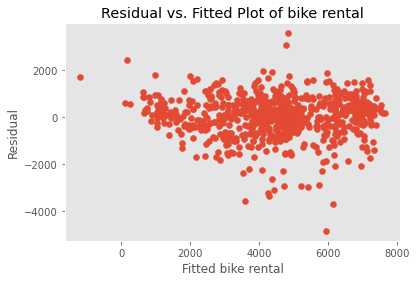

In [19]:
# plot 
plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid)
# adding title and labels
plt.xlabel('Fitted bike rental')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of bike rental')
plt.show()

Alternatively, we can use the 'Residual vs. predictor plot' for model diagnosis. As there are multiple variables, only one predictor can be displayed at a time.

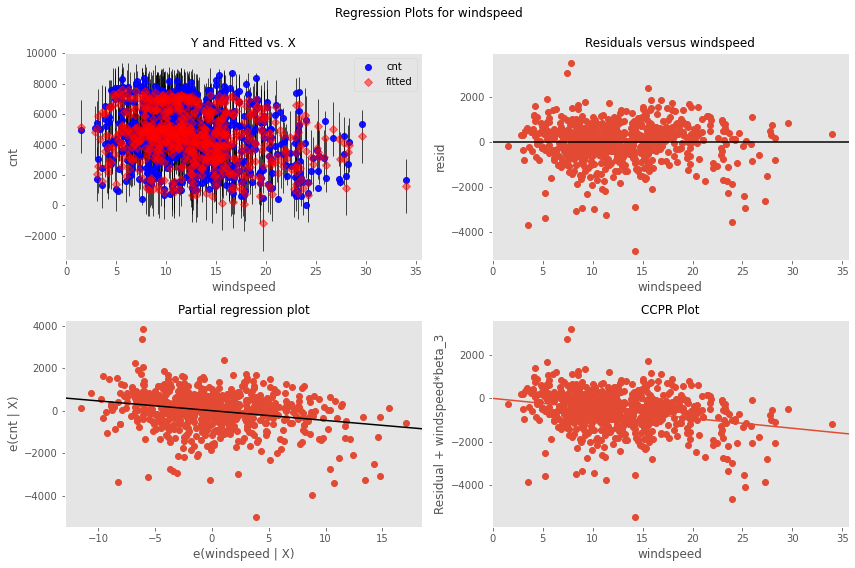

In [20]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_bike_rental, 'windspeed', fig=fig)

## Interpreting the model

The R-squared value is 0.798, meaning that 79.8% of the total variance of the bike rental can be explained by the variables used in the model.

**Can you interpret the coefficients for the windspeed and the season variables, using what we have learned from the lecture?**

**Another challenge: can you explain the meaning of the constant term, which is -4.257e+06?**

## Adjusted R-squared

In Section 3.1, in the summary of the linear regression model, there are two R-squared values:

result | value
-----|-----
R-squared | 0.798
Adjusted R-squared | 0.792

R-squared comes with an inherent problem: additional predictor variables will make the R-squared stay the same or increase, even if these variables show no relationship with the response varaible.

The adjusted R-squared is very useful for testing whether an additional variable improves the fitting performance.

As an example, assuming a new variable `totally_random`, we can compare the models without and with this variable, using the R-squared and adjusted R-squared value. 

**Can you compare the adjusted R-squared values here?**

In [36]:
df_predictors_adding_random = df_predictors_selected_VIF
# using a seed to make the result reproducible
np.random.seed(420)

# adding 'totally_random', which is random noise and shows no relationship with the response variable
df_predictors_adding_random['totally_random'] = np.random.normal(0,5,df_predictors_adding_random.shape[0])
# the model without windspeed
model_bike_rental_adding_random = sm.OLS(endog=bike_rental_final[['cnt']], exog=sm.add_constant(df_predictors_adding_random)).fit()
model_bike_rental_adding_random.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     121.9
Date:                Mon, 26 Oct 2020   Prob (F-statistic):          5.07e-228
Time:                        12:15:59   Log-Likelihood:                -5984.0
No. Observations:                 731   AIC:                         1.202e+04
Df Residuals:                     707   BIC:                         1.213e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.255e+06   1.33e+05    -32.028      0.000   -4.52e+06   -3.99e+06
yr                          2116.7531     66.026     32.059      0.000    1987.122    2246.385
hum                           -6.1431      3.233     -1.900      0.058     -12.491       0.205
windspeed                    -45.9254      6.917     -6.639      0.000     -59.506     -32.345
mnth_APR                    2403.4935    160.574     14.968      0.000    2088.234    2718.753
mnth_AUG                    3313.4320    160.630     20.628      0.000    2998.064    3628.800
mnth_DEZ                    1277.3539    160.416      7.963      0.000     962.405    1592.303
mnth_FEB                     429.7383    162.270      2.648      0.008     111.150     748.326
mnth_JUL                    3125.0873    160.856     19.428      0.000    2809.274    3440.901
mnth_JUN                    3368.5259    160.832     20.944      0.000    3052.761    3684.290
mnth_MAR                    1582.3696    158.963      9.954      0.000    1270.274    1894.465
mnth_MAY                    3125.7288    162.046     19.289      0.000    2807.580    3443.877
mnth_NOV                    1994.8837    161.401     12.360      0.000    1678.002    2311.766
mnth_OKT                    3141.7860    161.741     19.425      0.000    2824.236    3459.335
mnth_SEP                    3613.9696    164.607     21.955      0.000    3290.793    3937.146
weekday_FRI                  281.2755    122.706      2.292      0.022      40.363     522.187
weekday_SAT                  261.8871    122.156      2.144      0.032      22.056     501.719
weekday_SUN                 -194.6288    122.296     -1.591      0.112    -434.735      45.477
weekday_THU                  302.9838    122.680      2.470      0.014      62.123     543.844
weekday_TUE                  217.9342    122.346      1.781      0.075     -22.271     458.140
weekday_WED                  269.1638    122.862      2.191      0.029      27.945     510.383
weathersit_MISTY            -620.9061     86.784     -7.155      0.000    -791.291    -450.522
weathersit_RAIN/SNOW/STORM -2266.2825    223.319    -10.148      0.000   -2704.729   -1827.836
totally_random                 5.8414      6.499      0.899      0.369      -6.919      18.602
==============================================================================
Omnibus:                      128.501   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              400.676
Skew:                          -0.842   Prob(JB):                     9.87e-88
Kurtosis:                       6.212   Cond. No.                     8.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the 

# Linear regression without a constant

A special type of linear regression is the one without a constant (or intercept). In other words, the intercept is fixed as zero. As a result, the regression line should run through the origin, i.e., the point where both the response variable and all predictor variables equal zero. 

When you run the regression without a constant in the model, you are declaring that the expected value of `y` is 0 when `X` is equal to 0. This is the assumption behind this model.

If you fit two linear regression models on this dataset, one with a constant and one without, the coefficients and R-squared of the two modles are different.

In [172]:
model_bike_rental_no_constant = sm.OLS(endog=bike_rental_final[['cnt']], exog=df_predictors_selected_VIF).fit()
model_bike_rental_no_constant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              386.0
Date:                Sun, 25 Oct 2020   Prob (F-statistic):                        0.00
Time:                        20:07:58   Log-Likelihood:                         -6312.1
No. Observations:                 731   AIC:                                  1.267e+04
Df Residuals:                     709   BIC:                                  1.277e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
yr                             2.0432      0.201     10.156      0.000       1.648       2.438
hum                          -18.7010      5.020     -3.726      0.000     -28.556      -8.846
windspeed                    -54.4675     10.813     -5.037      0.000     -75.696     -33.239
mnth_APR                    2428.7473    251.183      9.669      0.000    1935.596    2921.898
mnth_AUG                    3365.0489    251.192     13.396      0.000    2871.880    3858.218
mnth_DEZ                    1354.0494    250.871      5.397      0.000     861.510    1846.589
mnth_FEB                     438.8423    253.814      1.729      0.084     -59.474     937.159
mnth_JUL                    3152.8380    251.616     12.530      0.000    2658.836    3646.840
mnth_JUN                    3368.6978    251.530     13.393      0.000    2874.866    3862.530
mnth_MAR                    1593.1607    248.619      6.408      0.000    1105.044    2081.278
mnth_MAY                    3235.2400    253.430     12.766      0.000    2737.677    3732.803
mnth_NOV                    2056.8893    252.455      8.148      0.000    1561.241    2552.538
mnth_OKT                    3262.2766    252.942     12.897      0.000    2765.672    3758.881
mnth_SEP                    3755.4571    257.396     14.590      0.000    3250.107    4260.807
weekday_FRI                  231.6087    191.859      1.207      0.228    -145.072     608.289
weekday_SAT                  228.9782    191.074      1.198      0.231    -146.161     604.118
weekday_SUN                 -193.5118    190.924     -1.014      0.311    -568.357     181.333
weekday_THU                  265.0931    191.806      1.382      0.167    -111.483     641.670
weekday_TUE                  214.4361    191.348      1.121      0.263    -161.240     590.112
weekday_WED                  283.4724    191.931      1.477      0.140     -93.349     660.294
weathersit_MISTY            -457.8965    135.516     -3.379      0.001    -723.957    -191.836
weathersit_RAIN/SNOW/STORM -2392.7896    349.252     -6.851      0.000   -3078.481   -1707.098
==============================================================================
Omnibus:                       55.651   Durbin-Watson:                   0.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.629
Skew:                           0.128   Prob(JB):                     3.32e-05
Kurtosis:                       2.218   Cond. No.                     2.42e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that 

# Building a logistic regression model

The bike rental company is interested to predict whether the daily rental would exceed 4,500. For this purpose, we can build a logistic regression model.

We will use the `scikit-learn` function to build this model.

**Can you explain this predictive accraucy of this model?**

------------------------------------------
Print the model:
yr : 0.0015035774879095323
hum : -0.037240126690879304
windspeed : -0.0941120415450212
mnth_APR : 0.35555345967953
mnth_AUG : 1.4479449022380315
mnth_DEZ : -0.47800067510086686
mnth_FEB : -2.2323748278613342
mnth_JUL : 1.0869244983063355
mnth_JUN : 1.9151653807863207
mnth_MAR : -0.06347574581468016
mnth_MAY : 1.3008258825133463
mnth_NOV : -0.040782504249209095
mnth_OKT : 1.1005631459071634
mnth_SEP : 1.6620648057069567
weekday_FRI : 0.0987369064275398
weekday_SAT : 0.15603094163556427
weekday_SUN : -0.04126055738604191
weekday_THU : 0.18450851946414326
weekday_TUE : 0.2529455368604554
weekday_WED : 0.2725024292907704
weathersit_MISTY : -0.41823377080939067
weathersit_RAIN/SNOW/STORM : -1.0841359408864437
------------------------------------------
Accuracy of the model is: 0.746922024623803
The confusion matrix is:


C:\Users\HuanfaChen\Anaconda3\envs\sds2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\HuanfaChen\Anaconda3\envs\sds2020\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<AxesSubplot:>

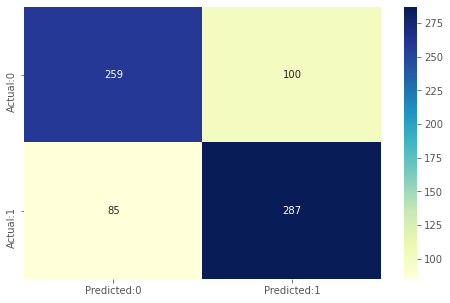

In [173]:
# If daily rental is larger than 4500, it is of Class 'True'. Otherwise, it is in Class 'False'.
threshold_bike_rental = 4500

X = df_predictors_selected_VIF
y = bike_rental_final[['cnt']] > threshold_bike_rental
###################

logreg = LogisticRegression()
logreg.fit(X, y)
y_pred=logreg.predict(X)

# print the coefficient in the model
print("------------------------------------------")
print("Print the model:")
coef_dict = {}
for coef, feat in zip(logreg.coef_.flatten().tolist(),X.columns):
    coef_dict[feat] = coef
    print(feat, ":", coef)
print("------------------------------------------")
    
acc = sklearn.metrics.accuracy_score(y,y_pred)
print("Accuracy of the model is: " + str(acc))

# Another evaluation: confusion matrix
print("The confusion matrix is:")
cm=confusion_matrix(y,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")